In [3]:
%%capture
!pip install git+https://github.com/huggingface/diffusers # need latest for hunyuan to be included

In [1]:
import torch
import torch.nn as nn
from diffusers import HunyuanVideoPipeline, HunyuanVideoTransformer3DModel

from taehv import TAEHV

class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

class TAEHVDiffusersWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.dtype = torch.float16
        self.taehv = TAEHV().to(self.dtype)
        self.config = DotDict(scaling_factor=1.0)

    def decode(self, latents, return_dict=None):
        n, c, t, h, w = latents.shape
        # low-memory, set parallel=True for faster + higher memory
        return (self.taehv.decode_video(latents.transpose(1, 2), parallel=False).transpose(1, 2).mul_(2).sub_(1),)

model_id = "hunyuanvideo-community/HunyuanVideo"
transformer = HunyuanVideoTransformer3DModel.from_pretrained(
    model_id, subfolder="transformer", torch_dtype=torch.bfloat16
)
pipe = HunyuanVideoPipeline.from_pretrained(model_id, transformer=transformer, torch_dtype=torch.float16).to("cuda")
pipe.vae = TAEHVDiffusersWrapper().to("cuda")

2025-03-03 04:07:34.719087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 04:07:34.737339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740974854.760292    4430 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740974854.767090    4430 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 04:07:34.787468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
output = pipe(
    prompt="a slice of delicious new-york style cheesecake with mint and berries is placed onto a plate and then drizzled with berry sauce",
    height=320,
    width=512,
    num_frames=61,
    num_inference_steps=30,
    generator=torch.Generator("cpu").manual_seed(0x7AE)
).frames[0]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]


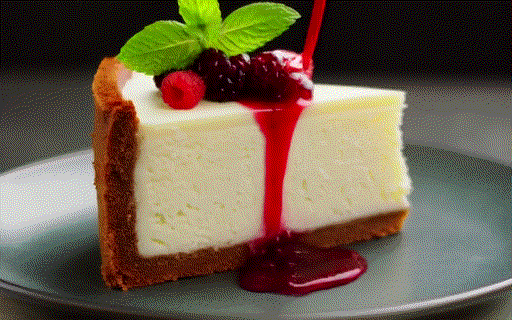

In [20]:
import torchvision.transforms.functional as TF
import io
import base64
from IPython.display import HTML

def frames_to_html(frames):
    """Display TCHW [0, 1] frame tensor as inline video on colab."""
    video_buff = io.BytesIO()
    frames[0].save(video_buff, append_images=frames[1:], save_all=True, duration_ms=1000/30, loop=0, format="GIF")
    video_buff.seek(0)
    video_b64 = base64.b64encode(video_buff.getvalue()).decode('utf-8')
    return HTML(f"<img src='data:image/gif;base64,{video_b64}'/>")

display(frames_to_html(output))